In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl
import pandas as pd

# import jupyternotify
import pylab as pl
import subprocess
import concurrent.futures
import shutil

# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)


In [2]:
# %%file cluster_configs/cre_setup_3_scale_1_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 10, 'europe-west3-c', 1, -1, 'FKA.pem', 1, -1,
# 11, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 9,
# 12, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 10,
# 13, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 11,
# 14, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 12,
# 15, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 13,
# 16, 'asia-south1-c', 1, -1, 'FKE.pem', 2, -1,

In [3]:
# %%file cluster_configs/cre_setup_1_scale_1_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 10, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,
# 11, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 9,
# 12, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 10,
# 13, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 11,
# 14, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 12,
# 15, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 13,
# 16, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [4]:
config_list = ['cre_setup_3_scale_1_node_info', 'cre_setup_1_scale_1_node_info']

In [5]:
# config_file = config_list[0]

In [6]:
def run_bftsmart_mc(config_file):


    os.system('cp cluster_configs/'+config_file+'.csv node_info.csv')


    df =pd.read_csv('node_info.csv')

    node_info_dict = df.to_dict()

    node_info_dict

    total_count = 0

    for key in node_info_dict['ServerOrClientregion'].keys():
        if node_info_dict['ServerOrClientregion'][key] ==0:
            total_count = total_count + 1

    total_count

    replica_count = 0

    for key in node_info_dict['cluster_id'].keys():
        if node_info_dict['cluster_id'][key] ==0:
            replica_count = replica_count + 1


    replica_count       

    node_info_dict

    n_clusters = int(total_count / replica_count)

    nclients = 0

    for i in node_info_dict['ServerOrClientregion']:
    #     print(node_info_dict['ServerOrClientregion'][i])
        if node_info_dict['ServerOrClientregion'][i] == 1:
            nclients = nclients + 1
    nclients

    clusters_tracked = []
    cluster_regions_tracked = []

    for key in node_info_dict['region']:
        if int(node_info_dict['cluster_id'][key]) not in clusters_tracked and int(node_info_dict['cluster_id'][key]) >=0:
            clusters_tracked.append(int(node_info_dict['cluster_id'][key]))
            cluster_regions_tracked.append(node_info_dict['region'][key].strip().replace('"', '')[1:-1])


    cluster_regions_tracked     

    cluster_regions_tracked, clusters_tracked


    regions = cluster_regions_tracked


    # regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b',\
    #            'europe-west3-c', 'europe-west3-c', 'europe-west3-c', 'europe-west3-c', \
    #            'asia-south1-c', 'asia-south1-c', 'asia-south1-c', 'asia-south1-c']


    # regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b']


    # regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b',\
    #            'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b', \
    #            'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b']



    # regions = [ 'europe-west3-c', 'asia-south1-c']

    # regions = [ 'us-west1-b', 'us-west1-b']



    # regions = [ 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b', 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b', 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b']
    # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b']



    # regions = ['europe-west3-c',  \
    #            'asia-south1-c']


    n_regions = len(regions)

    for i,k in enumerate(regions):
        print(i,k)

    for item, idx in enumerate(node_info_dict['region'].keys()):
        print(item, idx, node_info_dict['region'][item])

    lines  = []
    # zones = {}


    # lim = 0
    # for reg in regions:
    #     for i in range(replica_count+int(nclients/n_clusters)):
    #         line = 'gcloud compute instances create resdb-'+f"{lim+i:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'

    #         print(line)
    #         lines.append(line)
    #         zones[i] = reg

    #     lim = lim + replica_count+int(nclients/n_clusters)




    # with open('launch_cloud_instances.sh', 'w') as f:
    #     for item in lines:
    #         f.write(str(item) + '\n')


    for idx, key in enumerate( node_info_dict['region'].keys()):

        line = 'gcloud compute instances create resdb-'+f"{idx:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+node_info_dict['region'][key].strip()[1:-1]+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
        lines.append(line)

    with open('launch_cloud_instances.sh', 'w') as f:
        for item in lines:
            f.write(str(item) + '\n')


    len(lines), node_info_dict['region'][key].strip()[1:-1]


    def run_command(command):
        subprocess.call(command, shell=True)

    commands = lines

    # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
        # Submit each command to the executor for parallel execution
        futures = [executor.submit(run_command, command) for command in commands]

        # Wait for all tasks to complete
        concurrent.futures.wait(futures)

    time.sleep(30)

    # os.system('sh launch_cloud_instances.sh')

    for folder in os.listdir('.'):
        if 'config' in folder and folder!='config' and 'zip' not in folder and '.' not in folder:
            shutil.rmtree(folder)

    # os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

    # os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

    instance_type = 'e2-small'


    redirect = '>'

    os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_internal_ips')



    os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
          redirect+' all_external_ips')

    with open('all_internal_ips') as f:
        ipList = f.read().splitlines()
    ipList = [x for x in ipList if x!='None']

    ipList, len(ipList)

    new_server_only_ips= []
    new_client_only_ips= []



    for i in range(total_count + nclients):
        if node_info_dict['ServerOrClientregion'][i] ==0:
            new_server_only_ips = new_server_only_ips + [ipList[i]]
        else:
            new_client_only_ips = new_client_only_ips + [ipList[i]]



    # new_server_only_ips= []
    # new_client_only_ips= []


    # current_region_total = 0
    # for i in range(n_regions):
    #     print(current_region_total,current_region_total+ clusters_per_region_map[i] *replica_count)
    #     new_server_only_ips = new_server_only_ips + ipList[current_region_total:current_region_total+ clusters_per_region_map[i] *replica_count]

    #     new_client_only_ips = new_client_only_ips + ipList[current_region_total+ clusters_per_region_map[i] *replica_count:
    #                                                       current_region_total+ clusters_per_region_map[i] *(replica_count+1)]


    #     current_region_total = current_region_total + clusters_per_region_map[i] *replica_count +  clusters_per_region_map[i]

    new_server_only_ips, len(new_server_only_ips)

    new_client_only_ips, len(new_client_only_ips) 

    # ipList = new_server_only_ips + new_client_only_ips

    # ipList, len(ipList)

    nclients = 0
    nservers = 0
    count = 0

    clusterIpMap = {}


    for i in node_info_dict['ServerOrClientregion']:
    #     print(node_info_dict['ServerOrClientregion'][i])

        if node_info_dict['ServerOrClientregion'][i] == 0:
            clusterIpMap[nservers] = ipList[count]
            nservers = nservers + 1

        count = count + 1

    nclients = 0
    nservers = 0
    count = 0

    for i in node_info_dict['ServerOrClientregion']:
    #     print(node_info_dict['ServerOrClientregion'][i])

        if node_info_dict['ServerOrClientregion'][i] == 1:
            print('test: ', 7001+nclients, ipList[count])
            clusterIpMap[7001+nclients] = ipList[count]
            nclients = nclients + 1

        count = count + 1

    clusterIpMap

    # clusterIpMap = {}

    # for i in range(len(ipList)):
    #     clusterIpMap[i] = ipList[i]


    # for i in range(nclients):

    #     clusterIpMap[7001+i] = ipList[-(nclients-i)]

    clusterPortMap1 = {}
    clusterPortMap2 = {}

    for i in range(len(ipList) - nclients):

        clusterPortMap1[i] = str(10000)

    for i in range(len(ipList) - nclients):
        clusterPortMap2[i] = str(20000)

    # clusterPortMap1[7003] = '11400'
    # clusterPortMap2[7003] = '11410'



    temp = 11900

    for i in range(nclients):

        clusterPortMap1[7001+i] = str(10000)
        clusterPortMap2[7001+i] = str(20000)

    clusterPortMap1, clusterPortMap2

    os.system('echo 3108 | sudo -S ./gradlew installDist')

    for i in range(total_count):
        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(i)+' 1024')



    os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7002)+' 1024')
    os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7001)+' 1024')

    os.system('echo 3108 | sudo -S ./gradlew clean')

    for key in clusterPortMap1.keys():
        if key>7002:
    #         print(key)
            print()

            for folder in os.listdir('config/'):
                if os.path.isdir('config/'+folder) and 'keys' in folder:
                    if os.path.exists('config/'+folder+'/'+'privatekey7001'):
                        shutil.copy('config/'+folder+'/'+'privatekey7001','config/'+folder+'/'+'privatekey'+str(key))
                        shutil.copy('config/'+folder+'/'+'publickey7001','config/'+folder+'/'+'publickey'+str(key))

            print('----------')
            print()

    for i in range(n_clusters):

        if os.path.exists('config'+str(i)):
            shutil.rmtree('config'+str(i))

        os.mkdir('config'+str(i))
        os.mkdir('config'+str(i)+'/keysRSA')
        os.mkdir('config'+str(i)+'/keysSunEC')
        os.mkdir('config'+str(i)+'/keysECDSA')

    #     print('config'+str(i)+'/keysECDSA')


        shutil.copytree('config/workloads/', 'config'+str(i)+'/workloads')
        shutil.copytree('config/keysSSL_TLS/', 'config'+str(i)+'/keysSSL_TLS')
    #     print('config/workloads/', 'config'+str(i)+'/workloads')


        for file in os.listdir('config/keys/'):

            shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysRSA/'+file)
            shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysSunEC/'+file)
            shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysECDSA/'+file)


        shutil.copy('config/system.config', 'config'+str(i)+'/system.config')    
        shutil.copy('config/logback.xml', 'config'+str(i)+'/logback.xml')





    clusterIpMap, clusterPortMap1

    def find_key_by_value(dictionary, value):
        for key, val in dictionary.items():
            if val == value:
                return key
        # If the value is not found, you might want to handle this case accordingly.
        return None


    node_info_dict

    find_key_by_value(node_info_dict['ServerID'], 4)

    for n_cluster in range(n_clusters):

        with open('config'+str(n_cluster)+'/hosts.config','w') as file:

            for key in clusterIpMap:
                if key < 7000:
                    file.writelines(str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                    print('test: ',str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
            for key in clusterIpMap:
                if key >= 7000:
                    file.writelines(str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')
                    print('test: ', str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')

            file.close()


    # for n_cluster in range(n_clusters):

    #     with open('config'+str(n_cluster)+'/hosts.config','w') as file:

    #         for n_cluster1 in range(n_clusters):

    #             for i_replica in range(replica_count):
    #     #             file.writelines(str(i_replica)+' '+clusterIpMap[n_cluster*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster*replica_count+i_replica]+'\n')
    #                 file.writelines(str(n_cluster1*replica_count+i_replica)+' '+clusterIpMap[n_cluster1*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster1*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster1*replica_count+i_replica]+' '+str(n_cluster1)+'\n')

    #         for iter_ in range(len(ipList) - (n_clusters*replica_count)-nclients):
    #             print((n_clusters*replica_count) + iter_)

    # #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(iter_%n_clusters)+'\n')
    #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(0%n_clusters)+'\n')

    #         for i in range(nclients):
    #             file.writelines(str(7001+i)+' '+clusterIpMap[7001+i]+' '+clusterPortMap1[7001+i]+'\n')


    #         file.close()


    replica_count

    # for n_cluster in range(n_clusters):
    #     with open('config'+str(n_cluster)+'/system.config','r') as file:
    #         data = file.readlines()
    #         f = int(np.ceil((replica_count-1)/3))
    #         print('f is',f )

    #         for n_line in range(len(data)):
    #             if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


    #                 data[n_line] = 'system.servers.num = '+str(replica_count)
    #                 print(data[n_line])

    #             if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
    #                 data[n_line] = 'system.servers.f = '+str(f)
    #                 print(data[n_line])


    #             if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
    #                 data[n_line] = 'system.initial.view = '
    #                 for iter_view in range(replica_count):
    #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
    # #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
    #                     print(data[n_line])

    #                 data[n_line] = data[n_line][:-1]
    #                 print(data[n_line])



    #         file.close()

    #     with open('config'+str(n_cluster)+'/system.config', 'w') as f:
    #         for line in data:
    #             f.write(f"{line}\n")




    for n_cluster in range(n_clusters):
        with open('config'+str(n_cluster)+'/system.config','r') as file:
            data = file.readlines()


            nservers = 0
            server_id_list = []



            for i in node_info_dict['ServerOrClientregion']:
                if node_info_dict['ServerOrClientregion'][i] == 0 and \
                node_info_dict['cluster_id'][i]  == n_cluster:
                    nservers = nservers + 1
                    server_id_list.append(node_info_dict['ServerID'][i])

            f = int(np.ceil((nservers-1)/3))
            print('f is',f )


            for n_line in range(len(data)):
                if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


                    data[n_line] = 'system.servers.num = '+str(nservers)
                    print(data[n_line])

                if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
                    data[n_line] = 'system.servers.f = '+str(f)
                    print(data[n_line])


                if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
                    data[n_line] = 'system.initial.view = '
                    for iter_view in server_id_list:
                        data[n_line] = data[n_line] +str(iter_view)+','
    #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
                        print(data[n_line])

                    data[n_line] = data[n_line][:-1]
                    print(data[n_line])



            file.close()

        with open('config'+str(n_cluster)+'/system.config', 'w') as f:
            for line in data:
                f.write(f"{line}\n")


    for n_cluster in range(n_clusters):
        for i in range(400):

            for ncls in  range(1):


    #             print('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
    #                         'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))



                shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                            'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
                shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
                            'config'+str(n_cluster)+'/keysRSA/'+'privatekey'+str(1000+(ncls*100)+i))

    #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
    #                     'config'+str(n_cluster)+'/keysRSA/'+'publickey7002')

    #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
    #                     'config'+str(n_cluster)+'/keysRSA/'+'privatekey7002')

    # os.system('git remote set-url origin https://github.com/tmane002/BftSmart_Final.git')

    os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')

    time.sleep(30)

    # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b']
    # regions = [ 'us-west1-b']


    instance_type = 'e2-small'

    df =pd.read_csv('node_info.csv')

    node_info_dict = df.to_dict()

    node_info_dict

    f = open('all_external_ips', "r")
    data1 = [line.strip() for line in f.readlines()]

    data1 = [x for x in data1 if x!='None']

    f = open('all_internal_ips', "r")
    data2 = [line.strip() for line in f.readlines()]

    data2 = [x for x in data2 if x!='None']

    data2, len(data2)

    data = []

    skip_instances = 0

    for i in range(skip_instances, len(data1)):
        if data1[i]!='None':
            data.append(data1[i] + '    ' + data2[i])

    data, len(data)

    for index, item in enumerate(data1):
        if 'publicIP' not in node_info_dict.keys():
            node_info_dict['publicIP'] = {}


        node_info_dict['publicIP'][index] = item 


    for index, item in enumerate(data2):
        if 'privateIP' not in node_info_dict.keys():
            node_info_dict['privateIP'] = {}

        node_info_dict['privateIP'][index] = item 



    for index, item in enumerate(data):
        if 'publicAndprivateIP' not in node_info_dict.keys():
            node_info_dict['publicAndprivateIP'] = {}

        node_info_dict['publicAndprivateIP'][index] = item 

    node_info_dict









    # time.sleep(60)

    total_count = 0

    for key in node_info_dict['ServerOrClientregion'].keys():
        if node_info_dict['ServerOrClientregion'][key] ==0:
            total_count = total_count + 1

    total_count





    def getTimeThps(file, flag):

        f = open(file, "r")
        data = f.readlines() 

        times = []
        thputs = []
        for line in data:
            if 'throughput[ops/s]' in line:
                lineData = (line[13+line.find('max[ops/s])>'):-2])
                print(lineData)

                times.append(lineData.split('|')[0])
                thputs.append(lineData.split('|')[-2])
        if (flag): 
            times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
            thputs.append(0)

        return np.array(times).astype(float), np.array(thputs).astype(float) 

    with open('all_external_ips') as f:
        lines = f.read().splitlines()


    lines = [x for x in lines if x!='None']
    lines, len(lines)

    for ip in lines:
        if ip!='None':
            current = (ip.split('.'))

            print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

    ## Set number of clusters

    nclusters = 0

    for folder in os.listdir('.'):
        if 'config' in folder and folder!='config':
            nclusters = nclusters + 1


    print(nclusters)





    nreplicas = int(total_count/nclusters)
    nclients = nclusters


    nodeIps = []
    clientIps = []

    for i in range(total_count + nclients):
        if node_info_dict['ServerOrClientregion'][i] ==0:
            nodeIps.append(lines[i])
        else:
            clientIps.append(lines[i])


    # nodeIps = lines[:nclusters* nreplicas]


    # no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
    no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



    # clientIps = lines[-(nclusters):]



    # clientIps = lines[-nclients:]



    clientIps, no_cluster_yet_nodes



    node_info_dict

    node_info_dict['region'][0].strip()

    ## Functions

    def setup(i):

        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' commands.sh'+' resdb-'+f"{i:02}"+':/home/tejas/commands.sh'

            print(command)
            os.system(command)

    def initialize(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo sh commands.sh"'


            os.system(command)


    def git_clone(i):
        ip = lines[i]
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'


            os.system(command)

    def git_pull(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "git config --global --add safe.directory /home/tejas/BftSmart_Final; cd BftSmart_Final; sudo git pull"'


            os.system(command)

    def compile_job(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo ./gradlew installDist"'


            os.system(command)



    def clean_job(i):
        ip = node_info_dict['publicIP'][i] 

        rm_command = 'sudo rm config/currentView; '
        for iter_ in range(nclusters):
            rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '


        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'


            os.system(command)


    def clean_all(i):
        ip = node_info_dict['publicIP'][i] 

        rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'



        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; '+rm_command+'"'


            os.system(command)





    #     if ip!='None' and( ip in no_cluster_yet_nodes):

    #         current = (ip.split('.'))
    #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
    #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


    #         os.system(command)        
    # #         print(command)

    def check_node(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "tail -n 1000 nohup.out"'


            os.system(command)
    #         print(command)


    def run_basic_client(i):
        cmd_arg = ''

        ip = node_info_dict['publicIP'][i] 

        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

            current = (ip.split('.'))


            cmd_arg = str(node_info_dict['clientID'][i])



            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'


            os.system(command)


    def kill_java(i):
        ip = node_info_dict['publicIP'][i] 

        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo killall java; sudo killall nohup; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


            os.system(command)



    def kill_clients(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None' and ip in clientIps:
            current = (ip.split('.'))
            command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'


            os.system(command)

    def run_server_node_check(i):
        ip = node_info_dict['publicIP'][i] 

        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

            current = (ip.split('.'))
            command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


            print(command)



    # for i in range(len(lines)):
    #     run_server_node_check(i)

    def run_basic_client_check(i):
        cmd_arg = ''

        ip = node_info_dict['publicIP'][i] 
        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

            cmd_arg = str(node_info_dict['clientID'][i])


    #         print(i, cmd_arg)

            current = (ip.split('.'))
            command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'


            print(command)



    ## First Time Setup

    lines, len(lines)

    # for i in range(10):
    #     setup(i)


    results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
    print(results)  

    results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
    print(results)  

    # ## GIT Clone/Pull



    # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
    # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
    # # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


    # print(results)  

    # ## Compile Job

    results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
    print(results)  

    # ## CLEAN SERVERS

    # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
    # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

    # print(results)  

    results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


    def run_server_node(i):
        ip = node_info_dict['publicIP'][i] 
    #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(node_info_dict['ServerID'][i])+' >../nohup.out 2>&1 &"'


            os.system(command)



    # for i in node_info_dict['publicIP']:
    #     run_server_node(i)

    ## RUN SERVERS

    # results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
    # print(results)  

    ### CHECK NODE RESULT

    # check_node(0)

    # ## Run basic client

    # # time.sleep(20)
    # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
    # print(results)  

    # check_node(0)

    # time.sleep(60)

    # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

    # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

    ## Main Job

    # os.system('git add .; git commit -m "test";git push')

    experiment = 'cre_t_'+str(total_count)+'_clusters_'+str(nclusters)

    # time.sleep(60)

    os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')


    #     %%time


    # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

    results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

    results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
    # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

    results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
    # print(results) 





    results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
    # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


    results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
    # print(results)  


    print('XXXXXXXX Started Servers XXXXXXXXXXXX')

    time.sleep(40)

    check_node(7)



    print('XXXXXXXX Started Clients XXXXXXXXXXXX')

    results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))

    time.sleep(180)

    results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

    check_node(0)

    if not os.path.exists('../Experiments/'+experiment):
        os.mkdir('../Experiments/'+experiment)

    os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')



    for i in node_info_dict['publicIP']:
        ip = node_info_dict['publicIP'][i] 


        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
            current = (ip.split('.'))
            command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

            os.system(command)

            break;



    for i in node_info_dict['publicIP']:
        ip = node_info_dict['publicIP'][i] 



        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
            print('client copying id= ',i)
            current = (ip.split('.'))
            command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
            print(command)
            os.system(command)


    for i in node_info_dict['publicIP']:
        ip = node_info_dict['publicIP'][i] 


        print(i)
        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
            print('client copying id= ',i)


    node_info_dict

    clientIps



    def getTimesThputs(file):
        f = open(file, "r")
        data = f.readlines() 
        times = []
        thputs = []
        latencies = []
        for line in data:
    #         print(line)
            if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

    #         print(line)
                times.append(line.split('sec:')[0].strip())
                thputs.append(line.split(';')[1].split('current')[0].strip())
                latencies.append(line.split('=')[1].split(']')[0].strip())

                print(line,latencies[-1],thputs[-1],times[-1])

        return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  



    times_thputsDict = {}
    times_latsDict = {}

    for ip in clientIps[:1]:    
        i = clientIps.index(ip)

        times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

        print(times, thputs)
        for i in range(len(times)):
            times_thputsDict[times[i]] = thputs[i]
            times_latsDict[times[i]] = lats[i]


    for ip in clientIps[1:]:    
        i = clientIps.index(ip)

        times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


        for i in range(len(times)):

            if times[i] in times_thputsDict.keys():
                times_thputsDict[times[i]] += thputs[i]

            if times[i] in times_latsDict.keys():
                times_latsDict[times[i]] += lats[i]


    times_thputsDict



    PIK = '../Experiments/'+experiment+"/pickle.dat"

    data = [times_thputsDict, times_latsDict]

    with open(PIK, "wb") as f:
        pickle.dump(data, f)

    experiment

    # experiment = 'TestRun2_8_clusters_2'
    # PIK = '../Experiments/'+experiment+"/pickle.dat"

    data2 = []
    with open(PIK, "rb") as f:
        data2 =  pickle.load(f)


    dict1 = data2[0]
    dict2 = data2[1]



    times1 = np.array(list(dict1.keys()))
    thputs = np.array(list(dict1.values()))

    times2 = np.array(list(dict2.keys()))
    lats = np.array(list(dict2.values()))

    times1


    pl.figure(figsize = (12,8))
    pl.rcParams.update({'font.size': 17})
    pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


    pl.title(r'Throughput')


    pl.xlabel('Time (s)')
    pl.ylabel('Throughput (Txn/s)')
    pl.legend()
    pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
    pl.show()




    pl.figure(figsize = (12,8))
    pl.rcParams.update({'font.size': 17})
    pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


    pl.title(r'Latency')


    pl.xlabel('Time (s)')
    pl.ylabel('Latency (Txn/s)')
    pl.legend()
    pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
    pl.show()

    times1, lats

    lats, np.average(lats[-85:-5])/len(clientIps)

    np.sum(thputs),  np.average(thputs[-85:-5])

    thputs

    np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

    # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

    np.sum((thputs[:180]))

    np.sum((thputs[:180]))

0 europe-west3-c
1 europe-west3-c
2 asia-south1-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'asia-south1-c'
12 12  'asia-south1-c'
13 13  'asia-south1-c'
14 14  'asia-south1-c'
15 15  'asia-south1-c'
16 16  'asia-south1-c'


ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/z

test:  7001 10.156.0.5
test:  7002 10.156.0.111
test:  7003 10.160.0.87


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 978ms
3 actionable tasks: 3 executed


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 486ms
1 actionable task: 1 executed

----------

test:  0 10.156.0.8 10000 20000 0

test:  1 10.156.0.3 10000 20000 0

test:  2 10.156.0.97 10000 20000 0

test:  3 10.156.0.91 10000 20000 0

test:  4 10.156.0.11 10000 20000 1

test:  5 10.156.0.110 10000 20000 1

test:  6 10.156.0.112 10000 20000 1

test:  7 10.156.0.12 10000 20000 1

test:  8 10.156.0.2 10000 20000 1

test:  9 10.160.0.48 10000 20000 2

test:  10 10.160.0.85 10000 20000 2

test:  11 10.160.0.35 10000 20000 2

test:  12 10.160.0.30 10000 20000 2

test:  13 10.160.0.4 10000 20000 2

test:  7001 10.156.0.5 10000

test:  7002 10.156.0.111 10000

test:  7003 10.160.0.87 10000

test:  0 10.156.0.8 10000 20000 0

test:  1 10.156.0.3 10000 20000 0

test:  2 10.156.0.97 10000 20000 0

test:  3 10.156.0.91 10000 20000 0

test:  4 10.156.0.11 10000 20000 1

test:  5 10.156.0.110 10000 20000 1

test:  6 10.156.0.112 10000 20000 1

test:  7 10.156.0.12 10000 20000 1

test:  8 10.156.0.2 10000 200

To github.com:tmane002/BftSmart_Final.git
   4232f2ee..048747b7  main -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-8.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-3.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-97.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-91.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-11.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-110.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-112.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-12.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-2.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-5.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-111.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-48.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-85.us-west-1.compute.a

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 P

Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:4 http://security.ubuntu.com/ub

Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1142 kB]
Get:15 http://europe-west3.gce.ar

Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5504 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadat

Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [405 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5504 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata

Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [405 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Meta

Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InR


Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b


Reading package lists...
Building dependency tree...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 l

Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-pe

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.7) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5

Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Fetched 29.7 MB in 6s (5360 kB/s)
Reading package lists...Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unp


Reading state information...

Reading package lists...Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...

Building dependency tree...Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Fetched 29.7 MB in 6s (5030 kB/s)
Reading package lists...Fetched 29.7 MB in 6s (4613 kB/s)
Reading package lists...


Fetched 29.7 MB in 6s (4584 kB/s)
Reading package lists...Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...

Reading state information...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejav

Fetched 29.7 MB in 6s (5020 kB/s)
Reading package lists...The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 lib

Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri 


Reading state information...
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.

Reading package lists...Building dependency tree...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-


Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common lib

Reading package lists...Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Selecting previously unselected package libalgorithm-diff-xs-perl.

The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal

Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Reading package lists...Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:36 



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-de

Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Unpacking build-essential (12.8ubuntu1.1) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Selecting previously unselected package libalgorithm-merge-perl.
Reading package lists...Fetched 48.2 MB in 1s (54.5 MB/s)
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...

The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
Building dependency tree...  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
Selecting previously unselect

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 1s (47.5 MB/s)
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]

Reading state information...
Get:14 http://asia-south1.gce.archive.ubun

Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Get:35 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:38 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Get:39 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.
Setting up g++ (4:9.3.0-1ubuntu2) ...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Fetched 48.2 MB in 1s (40.5 MB/s)
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:

Selecting previously unselected package libctf0:amd64.
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...

debconf: falling back to frontend: Readline
Selecting previously unselected package binutils-common:amd64.
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Fetched 48.2 MB in 3s (15.8 MB/s)
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Selecting previously unselected package libisl22:amd64.
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubu

Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.7 [1614 kB]
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking binutils-common:amd64 (2.34-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Unpacking binutils (2.34-6ubuntu1.7) ...
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Fetched 48.2 MB in 3s (17.4 MB/s)
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutil

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libcrypt-dev:amd64.
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell b

Selecting previously unselected package cpp-9.
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unp

Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libctf0:amd64.
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../08-libc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously 

Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package cpp.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libc6-dev:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1u

Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Selecting previously unselected package cpp-9.
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libisl22:amd64.
Selecting pre

Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1u

Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package build-essential.
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libfakeroot:amd64.
Selec

Setting up libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Setting up libalgorithm

Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package gcc.
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package fakeroot.
Setting up manpages-dev (5.05-1) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~

update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package manpages-dev.
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender

update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.


Selecting previously unselected package manpages-dev.
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ub

Setting up g++ (4:9.3.0-1ubuntu2) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...Selecting previously unselected package build-essential.
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode

Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Setting up build-essential (12.8ubuntu1.1) ...
Building dependency tree...Unpacking build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 h

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking fakeroot (1.24-1) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (4733 kB/s)
Setting up gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-merge-perl.
Selecting previously unselected package fakeroot.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Unpacking fakeroot (1.24-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_

Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils-common:amd64.
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
(Reading database ... 62221 files and directories currently installed.)
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (5047 kB/s)
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.7) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers fo

job.sh: 12: sdk: not found


Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...

Reading state information...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs

job.sh: 12: sdk: not found



Reading state information...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Select

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Fetched 43.0 MB in 2s (18.2 MB/s)
Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpackin

Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
update-alternatives: using /us

Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /etc/ssl/certs...
Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
A

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
Reading package lists...
Building dependency tree...Reading package lists...
Reading state information...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this opera

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Reading package lists...
Fetched 396 kB in 0s (4521 kB/s)
Building dependency tree...
Reading state information...Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...

Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and directories currently i

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Fetched 396 kB in 0s (4551 kB/s)
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 l

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (5167 kB/s)
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Fetched 396 kB in 1s (448 kB/s)
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
Reading package lists...
Building dependency tree...Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and d

job.sh: 12: sdk: not found



Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Fetched 396 kB in 1s (450 kB/s)
(Reading database ... 55%
Reading state information...
The following packages will be upgraded:
  curl libcurl4
Reading package lists...(Reading database ... 75%
Building dependency tree...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
Fetched 396 kB in 1s (536 kB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Reading package lists...
Building dependency tree...(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.y

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Selecting previously unselected package java-common.

Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Building dependency tree...0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://europe-west3.gce.archiv

job.sh: 12: sdk: not found


Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre cups-common
  liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgra

job.sh: 12: sdk: not found


Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antl

Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre cups-common
  liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Get:2 http://europe-west3.gce.archive.ubuntu.co

job.sh: 12: sdk: not found


Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-up

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Fetched 396 kB in 1s (542 kB/s)
Setting up curl (7.68.0-1ubuntu2.21) ...
Reading package lists...Fetched 43.0 MB in 1s (29.9 MB/s)
Processing triggers for man-db (2.9.1-1) ...

Selecting previously unselected package ca-certificates-java.
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 j

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found



Reading state information...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Selecting previously unselected package libcups2:amd64.
'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package libavahi-client3:amd64.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libcups2:amd64.

Readi

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
Selecting previously unselected package fontconfig-config.
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Selecting previously unselected package libjpeg8:amd64.
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previ

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
The following packages were automatically installed and are no longer required:
Selecting previously unselected package libjpeg8:amd64.
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Sug

Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Fetched 43.0 MB in 3s (14.1 MB/s)
Selecting previously unselected package ca-certificates-java.
(

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 43.0 MB in 1s (47.8 MB/s)
Selecting previously unselected package ca-certificates-java.
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Reading package lists...Fetched 43.0 MB in 4s (11.8 MB/s)

Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package libharfbuzz0b:amd64.
Building dependency tree...Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
(Reading database ... 67840 files and directories currently installed.)
Prepa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Selecting previously unselected package libharfbuzz0b:amd64.
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.y

Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
(Reading database ... 67840 files and directories currently installed.)
Setting up ant (1.10.7-1) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically installed and are no longer required:
  liba

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Selecting previously unselected package ant-optional.
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pemUnpacking ant-optional (1.10.7-1) ...

Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pemSelecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...

Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding de

Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Unpacking fonts-dejavu-core (2.37-1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
update-alternati

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Selecting previously unselected package ant-optional.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless am

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Setting up default-jre-headless (2:1.11-72) ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Fetched 43.0 MB in 3s (13.3 MB/s)
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-altern

head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:E-Tugra_Certification_Authority.pem
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Adding debian:DigiCert_Trusted_Root_G4.pemUnpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...

Adding debian:DigiCert_Trusted_Root_G4.pemAdding debian:E-Tugra_Global_Root_CA_ECC_v3.pem

Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:GTS_Root_R2.pem

Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding 


                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

job.sh: 12: sdk: not found


Adding debian:ISRG_Root_X1.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:GTS_Root_R1.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
done.
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pemAdding debian:GTS_Root_R3.pem
Adding debian:Izenpe.com.pem
Setting up ant-optional (1.10.7-1) ...

Adding debian:GlobalSign_ECC_Root_CA_-_R5.pemAdding debian:COMODO_RSA_Certification_Authority.pem

Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:

Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Setting up java-common (0.72) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode

Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
done.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto 

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode

Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Au

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Reading package lists...
Building dependency tree...Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Selecting previously unselected package libavahi-common-data:amd64.
P

Adding debian:Certigna.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Selecting previously unselected package libjpeg8:amd64.
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Adding debian:GlobalSign_Root_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Amazon_Root_CA_3.pemAdding debian:ANF_Secure_Server_Root_CA.pem

Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode

Adding debian:Aff

Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
done.
done.
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Security_Communication_Root_CA.pem
Processing triggers for man-db (2.9.1-1) ...
done.
done.
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pemProcessing triggers for libc-bin (2.31-0ubuntu9.9) ...

Processing triggers for man-db (2.9.1-1) ...
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:Dig

0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...

Reading state information...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...

Reading state information...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremov

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Building dependency tree...
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
update-alternatives: using /usr/lib/jvm/java

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Unpacking ant-optional (1.10.7-1) ...
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...

Reading state information...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up ant (1.10.7-1) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3)

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Addi

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Addin

Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:Certigna.pemAdding debian:certSIGN_ROOT_CA.pem

Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pemAdding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem

Selecting previously unselected package default-jre-headless.
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:AffirmTrust_Networking.pemPreparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...

Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Unpacking default-jre-headless (2:1.11-72) ...
Adding debian:D-TRUST_BR_Root_CA_1_2020.pemAdding debian:DigiCert_Assured_ID_Root_CA.pem

Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_R

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:GTS_Root_R1.pemAdding debian:IdenTrust_Commercial_Root_CA_1.pem

Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:GTS_Root_R3.pem
Adding debian:Hon

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding d

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.

Reading state information...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
...............................Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
10%...10%.............................10%......20%..........20%................................10%..30%...10%........30%............40%..............................50%....40%.............20%................60%...50%..................................70%.10%....60%...............................70%...80%......10%.20%......10%...................80...30%.90%.20%.%..................10%.....................90%....100%
................40%...........100%
..................30%.........50%........................20%...30%...........40%.......60%.20%........10%.........20%...................40%......70%.....20%.....50%...............................50%.....................60%.....80%....30%.........10%..............60%.


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 25s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 25s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 38s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 38s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 39s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 40s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 45s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

[main b54a4264] Working with modified ClusterInfo
 1 file changed, 16410 insertions(+), 112 deletions(-)


To github.com:tmane002/BftSmart_Final.git
   048747b7..b54a4264  main -> main
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
java: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
java: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
java: no process found
java: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no proc

Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main


Updating 048747b7..b54a4264
Fast-forward
Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main


Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main


Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main


Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main


Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   048747b7..b54a4264  main       -> origin/main


Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
Updating 048747b7..b54a4264
Fast-forward
Updating 048747b7..b54a4264
Fast-forward
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
 cre_exp_gc.ipynb | 16522 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 16410 insertions(+), 112 deletions(-)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be 

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory


XXXXXXXX Started Servers XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.0.12, 10.156.0.12
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:2  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:3  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:4  ## CipherSuite: TLS_ECDHE_ECDSA_W

nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

-- I'm at consensus -1 and my last consensus is 15791
-- Out of context msg with id 15791, type: 15791
-- Received read-only TOMMessage from client 1001 with sequence number 12361 for session -1156888220
-- deliverUnordered READ ONLY
[INFO] Processing an unordered request with aRequest.getType() being READ
-- --> 2: sending TOMMessage from: 0 -> [1001]
-- Received read-only TOMMessage from client 1002 with sequence number 12368 for session -700887599
-- deliverUnordered READ ONLY
[INFO] Processing an unordered request with aRequest.getType() being READ
-- --> 2: sending TOMMessage from: 0 -> [1002]
-- Received read-only TOMMessage from client 1001 with sequence number 12362 for session -1156888220
-- deliverUnordered READ ONLY
[INFO] Processing an unordered request with aRequest.getType() being READ
-- --> 2: sending TOMMessage from: 0 -> [1001]
-- Received read-only TOMMessage from client 1002 with sequence number 12369 for session -700887599
-- deliverUnordered READ ONLY
[INFO] Proce

-- Sending message from:0 -> to:13.
-- Sending message from:0 -> to:10.
-- OtherClusterMessage Sent to [4, 5, 6, 7, 8, 9, 10, 11, 12, 13], with type 2
-- saving msg for execution, with tid: 15794, requests: [[[1005:1943050274:2175]]]
-- Ending MC for cId:15794,  MCLatency: 821826
-- Main LOOP othermsgs_received_mc for tid: 15794, is temp size, nclusters is 1, 3, temp keyset [0]
-- othermsgs_received_mc for tid: 15794, is temp size, nclusters is 1, 3, temp keyset [0]
--  cid =15794, Memory Used: 174.56945037841797 MB, size of SavedMultiClusterMessages = 95,Sizeof  SavedDecisionsToBeExecuted 0, sizeof  SavedMessagesForExec95, sizeof decided = 0, sizeof LastDecisionSaved 95, usedMemory: 199911424
-- zsdqwd Before the prewait
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 2, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ------CHECKING LIMITS----------
-- Received message  type=ACCEPT, number=15794, epoch=0, from=2
-- I'm at consensus 1

rm: cannot remove '*': No such file or directory
rm: cannot remove 'cre_t_14_clusters_3.png': No such file or directory


client copying id=  9
gcloud compute scp --zone "europe-west3-c" resdb-09:/home/tejas/nohup_client.out ../Experiments/cre_t_14_clusters_3/nohup_client_0.out
client copying id=  10
gcloud compute scp --zone "europe-west3-c" resdb-10:/home/tejas/nohup_client.out ../Experiments/cre_t_14_clusters_3/nohup_client_1.out
client copying id=  16
gcloud compute scp --zone "asia-south1-c" resdb-16:/home/tejas/nohup_client.out ../Experiments/cre_t_14_clusters_3/nohup_client_2.out
0
1
2
3
4
5
6
7
8
9
client copying id=  9
10
client copying id=  10
11
12
13
14
15
16
client copying id=  16
 1 sec: 32 operations; 31.56 current ops/sec; [READ AverageLatency(us)=41839.75] 
 41839.75 31.56 1
 3 sec: 53 operations; 21 current ops/sec; [READ AverageLatency(us)=6089.15] [UPDATE AverageLatency(us)=2084230.5] 
 6089.15 21 3
 4 sec: 323 operations; 270 current ops/sec; [READ AverageLatency(us)=5661.59] [UPDATE AverageLatency(us)=165631.74] 
 5661.59 270 4
 5 sec: 498 operations; 174.83 current ops/sec; [READ Av

 2 sec: 193 operations; 192.81 current ops/sec; [READ AverageLatency(us)=11941.25] [UPDATE AverageLatency(us)=239864.12] 
 11941.25 192.81 2
 3 sec: 376 operations; 182.63 current ops/sec; [READ AverageLatency(us)=2317.95] [UPDATE AverageLatency(us)=279597.52] 
 2317.95 182.63 3
 4 sec: 571 operations; 194.81 current ops/sec; [READ AverageLatency(us)=1321.48] [UPDATE AverageLatency(us)=250416.71] 
 1321.48 194.81 4
 5 sec: 860 operations; 289 current ops/sec; [READ AverageLatency(us)=1123.04] [UPDATE AverageLatency(us)=195543.1] 
 1123.04 289 5
 6 sec: 1244 operations; 383.62 current ops/sec; [READ AverageLatency(us)=1035.32] [UPDATE AverageLatency(us)=165770.59] 
 1035.32 383.62 6
 7 sec: 1527 operations; 283 current ops/sec; [READ AverageLatency(us)=797.23] [UPDATE AverageLatency(us)=178853.63] 
 797.23 283 7
 8 sec: 1876 operations; 349 current ops/sec; [READ AverageLatency(us)=830.11] [UPDATE AverageLatency(us)=162145.78] 
 830.11 349 8
 9 sec: 2316 operations; 439.12 current ops/s

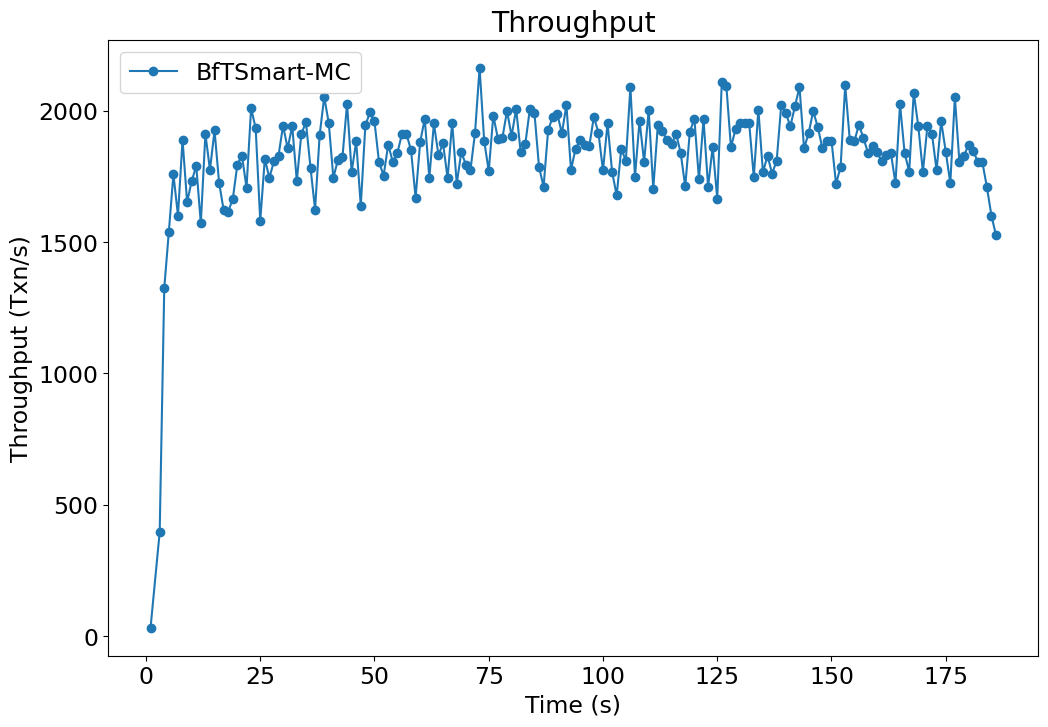

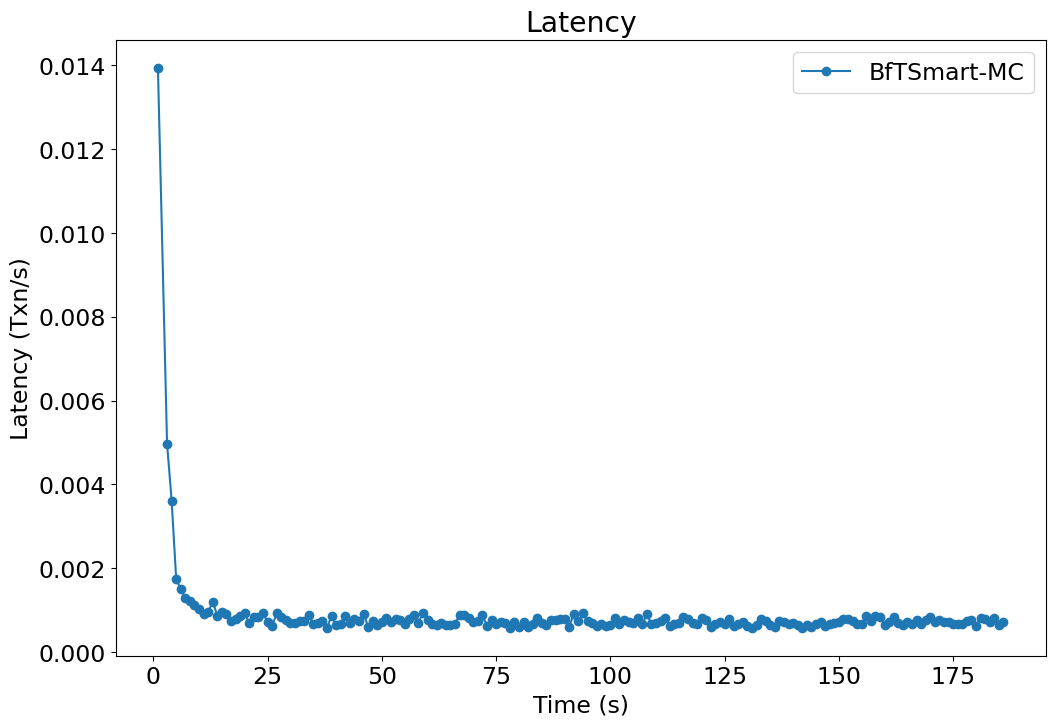

Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
Deleted 

0 europe-west3-c
1 europe-west3-c
2 asia-south1-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'asia-south1-c'
12 12  'asia-south1-c'
13 13  'asia-south1-c'
14 14  'asia-south1-c'
15 15  'asia-south1-c'
16 16  'asia-south1-c'


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-13].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-14].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-13  asia-south1-c  e2-highmem-2               10.160.0.29  34.93.255.193  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.6   34.89.133.102  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-14  asia-south1-c  e2-highmem-2               10.160.0.80  34.100.226.208  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.4   34.107.0.56  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-16].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.9   35.246.193.35  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-09].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.0.24  34.159.63.63  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-16  asia-south1-c  e2-highmem-2               10.160.0.86  35.244.15.197  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.17  34.159.126.10  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.0.13  34.107.80.212  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.25  34.159.23.30  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-11].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.0.15  34.107.45.189  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.10  34.89.226.117  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-11  asia-south1-c  e2-highmem-2               10.160.0.89  34.100.223.48  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.0.23  34.107.79.172  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.14  34.89.178.12  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-15].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-15  asia-south1-c  e2-highmem-2               10.160.0.91  35.200.207.90  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-12].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-12  asia-south1-c  e2-highmem-2               10.160.0.93  34.93.134.53  RUNNING
test:  7001 10.156.0.17
test:  7002 10.156.0.15
test:  7003 10.160.0.86


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 837ms
3 actionable tasks: 3 executed


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 419ms
1 actionable task: 1 executed

----------

test:  0 10.156.0.9 10000 20000 0

test:  1 10.156.0.10 10000 20000 0

test:  2 10.156.0.14 10000 20000 0

test:  3 10.156.0.6 10000 20000 0

test:  4 10.156.0.23 10000 20000 1

test:  5 10.156.0.24 10000 20000 1

test:  6 10.156.0.25 10000 20000 1

test:  7 10.156.0.13 10000 20000 1

test:  8 10.156.0.4 10000 20000 1

test:  9 10.160.0.89 10000 20000 2

test:  10 10.160.0.93 10000 20000 2

test:  11 10.160.0.29 10000 20000 2

test:  12 10.160.0.80 10000 20000 2

test:  13 10.160.0.91 10000 20000 2

test:  7001 10.156.0.17 10000

test:  7002 10.156.0.15 10000

test:  7003 10.160.0.86 10000

test:  0 10.156.0.9 10000 20000 0

test:  1 10.156.0.10 10000 20000 0

test:  2 10.156.0.14 10000 20000 0

test:  3 10.156.0.6 10000 20000 0

test:  4 10.156.0.23 10000 20000 1

test:  5 10.156.0.24 10000 20000 1

test:  6 10.156.0.25 10000 20000 1

test:  7 10.156.0.13 10000 20000 1

test:  8 10.156.0.4 10000 20000 

To github.com:tmane002/BftSmart_Final.git
   b54a4264..db0a1947  main -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-9.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-10.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-14.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-6.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-23.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-24.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-25.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-13.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-4.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-17.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-15.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-89.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-93.us-west-1.compute.ama

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 P

Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/ma

Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1142 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:22 http://europe-west3.gce.archi

Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:23 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:10 http://europe-west3.gce.ar

Get:24 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [405 kB]
Get:25 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:26 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:27 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:28 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:29 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [405 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]
Get:30 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:31 http

Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [405 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubu

Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translat

Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu


Reading state information...



The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b libice6
  libjpeg-turbo8 lib

The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1


Reading state information...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.7 [1614 kB]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 li

Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:40 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://europe-west3.gce.archive.ubuntu.com/u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libal

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libal

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Fetched 48.2 MB in 2s (25.4 MB/s)
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-x86-64-

Reading package lists...Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Reading package lists...
Fetched 29.7 MB in 6s (5390 kB/s)
Reading package lists...Building dependency tree...


Reading state information...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Fetched 29.7 MB in 6s (5285 kB/s)
Reading package lists...Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package li

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b libice6
  libjpeg-turbo8 libj

Reading package lists...
Building dependency tree...The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6

Reading package lists...Selecting previously unselected package libubsan1:amd64.
1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.1

Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Fetched 29.7 MB in 7s (4555 kB/s)
Reading package lists...Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]

Reading state information...
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd6

Reading package lists...Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...

Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Building dependency tree...Reading package lists...
Building dependency tree...
Fetched 29.7 MB in 7s (4360 kB/s)
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 

  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1 libxxf86vm1
  mesa-vulkan-drivers openjdk-11-jre openjdk-11-jre-headless x11-common
  x11-utils
0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.

Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...

Reading

Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]

Reading state information...
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 lib


Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri li



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Fetched 48.2 MB in 1s (66.3 MB/s)
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Reading package lists...Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]

Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Building dependency tree...Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...

Reading state information...
  libc6g database ... 80%
1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutil

Unpacking g++ (4:9.3.0-1ubuntu2) ...Setting up manpages-dev (5.05-1) ...

(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...Selecting previously unselected package libfakeroot:amd64.

Setting up libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Unpacking make (4.2.1-1.2) ...
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package build-essential.
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfont

Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up libfakeroot:amd64 (1.24-1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up fakeroot (1.24-1) ...
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
  libatk1.

Setting up manpages-dev (5.05-1) ...
Building dependency tree...Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf

Setting up build-essential (12.8ubuntu1.1) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...

Reading state information...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Processing triggers for man-db (2.9.1-1) ...
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libctf0:amd64.
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Get:30 http://europe-west3.gce.archive.ubuntu.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:40 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Processing triggers for man-db (2.9.1-1) ...
Fetched 48.2 MB in 1s (34.6 MB/s)
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Fetched 48.2 MB in 1s (36.9 MB/s)
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-g

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main a

Selecting previously unselected package libc6-dev:amd64.
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Selecting previously unselected package binutils.
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/m

Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:40 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package binutils-common:amd64.
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Selecting previously u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Selecting previously unselected package binutils-x86-64-linux-gnu.
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Get:42 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Selecting

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Selecting previously unselected package libc-dev-bin.
Fetched 48.2 MB in 3s (16.1 MB/s)
Selecting previously unselected package linux-libc-dev:amd64.
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Get:25 http://asia-sou

Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Selecting previously unselected package libitm1:amd64.
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/ma

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Fetched 48.2 MB in 3s (16.6 MB/s)
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libctf0:amd64.
Selecting previously unselected package cpp.
Selecting previously unselected package binutils-common:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils-common:amd64.
Unp

dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 75%
Selecting previously unselected package libitm1:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Selecting previously unselected package libmpc3:amd64.
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Selecting previously unselected package cpp-9.
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Unpacking libm

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Get:42 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 man

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libatomic1:amd64.
Preparing 

Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected packag

Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Selecting previously unselected package liblsan0:amd64.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package cpp.
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubun

Selecting previously unselected package gcc-9.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package dpkg-dev.
Selecting previously unselected package gcc.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Selecting previously unselected package build-essential.
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpac

Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package cpp.
Selecting previously unselected package gcc-9.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libalgorithm-diff-xs-perl

Setting up build-essential (12.8ubuntu1.1) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up fakeroot (1.24-1) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package g++.
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package liblsan0:amd64.
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...


Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Selecting previously unselected package g++-9.
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Preparing to unpack .../17

update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up make (4.2.1-1.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package build-essential.
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting

Setting up g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libfakeroot:amd6

Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Selecting previously unselected package build-essential.
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Setting up fakeroot (1.24-1) ...
Setting up binutils (2.34-6ubuntu1.7) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libgcc-9-dev:amd64 (9.4.

Setting up gcc (4:9.3.0-1ubuntu2) ...
The following packages will be upgraded:
  curl libcurl4
Setting up manpages-dev (5.05-1) ...

Selecting previously unselected package libalgorithm-merge-perl.
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Setting up binutils-common:amd64 (2.34-6ubuntu1.7) ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Selecting previously unselected package libfile-fcntllock-perl.
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Fetched 396 kB in 0s (1703 kB/s)
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Fetched 396 kB in 0s (5267 kB/s)
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...

Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ..

 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found



Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-ja

job.sh: 12: sdk: not found


  liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
Reading package lists...  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless

Building dependency tree...0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 43.0 MB in 1s (35.3 MB/s)
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) .

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../1

Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk

done.
Setting up ant-optional (1.10.7-1) ...
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Updating certificates in /etc/ssl/certs...
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Aut

Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
done.
done.

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Updating certificates in /etc/ssl/certs...
Processing triggers for man-db (2.9.1-1) ...
done.
done.
Processing triggers for libc-bin (2.31-0u

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Reading package lists...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Building dependency tree...

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
Fetched 396 kB in 0s (4911 kB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
The following packages will be upgraded:
  curl libcurl4
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
2 upgraded, 0 newly installed, 0 to remo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (5045 kB/s)
(Reading database ... 67840 files and directories currently installed.)Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading package lists...Building dependency tree...
Building dependency tree...Reading package lists...
Building dependency tree...
Reading state information...
Reading state information...

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
The following packages

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Fetched 396 kB in 0s (5000 kB/s)
(Reading database ... 95%Reading database ... 
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
The foll

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 396 kB in 1s (473 kB/s)
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
Fetched 396 kB in 1s (539 kB/s)
Fetched 396 kB in 0s (4935 kB/s)
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
(Readin

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists...
Building dependency tree...Fetched 396 kB in 0s (5039 kB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...

Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages were automatically in

job.sh: 12: sdk: not found


Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://europe-west3.gce.archive.ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...

Building dependency tree...Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested pac

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Selecting previously unselected package libcups2:amd64.
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpe

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Selecting previously unselected package libfontconfig1:amd64.
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../1

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...Selecting previously unselected package libpcsclite1:amd64.

Building dependency tree...Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Fetched 43.0 MB in 1s (38.9 MB/s)
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package ca-certificates-java.


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Fetched 43.0 MB in 1s (46.0 MB/s)
Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
(Reading database ... 70%
Reading state information...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...

Reading state information...
Selecting

job.sh: 12: sdk: not found


Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...

Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package liblcms2-2:amd64.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-hea

Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
The following packages will be upgraded:
  curl libcurl4
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your fa

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Fetched 396 kB in 0s (5077 kB/s)
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7

0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updat

job.sh: 12: sdk: not found


Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
The following additional packages will be installed:
  libcurl4
Selecting previously unselect

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Selecting previously unselected package fontconfig-config.
Selecting previously unselected package java-common.
Preparing to unpack .

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package liblcms2-2:amd64.
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
(Reading 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Selecting previously unselected package fonts-dejavu-core.
Fetched 396 kB in 1s (505 kB/s)
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Selecting previously unselected package libavahi-common3:amd64.
Unpacking fonts-dejavu-core (2.37-1) ...
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...

Reading state information...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2

Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      h

job.sh: 12: sdk: not found


Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]

Reading state information...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Selecting previously unselected package ant

           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...
Reading state information...
Fetched 43.0 MB in 3s (15.2 MB/s)
Selecting previously unselected p

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Selecting previously unselected package default-jre-headless.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:COMODO_Certification_Authority.pem
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:E-Tugra_Certification_Authority.pem
Fetched 43.0 MB in 6s (6994 kB/s)
Adding debian:DigiCert_Trusted_Root_G4.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package ope

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package libcups2:amd64.
Adding debian:Hongkong_Post_Root_CA_1.pem
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:CFCA_EV_ROOT.pem
Addi

job.sh: 12: sdk: not found


Adding debian:Izenpe.com.pem
Selecting previously unselected package libavahi-common3:amd64.
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Selecting previously unselected package fontconfig-config.
Updating certificates in /etc/ssl/certs...
Selecting previously unselected package libavahi-client3:amd64.
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Preparing to unpack .../04-libavahi-client3_0.

Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Selecting previously unselected package libharfbuzz0b:amd64.
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Certainly_Root_R1.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need

Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Setting up fonts-dejavu-core (2.37-1) ...
Adding debian:AffirmTrust_Commercial.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pemAdding debian:Amazon_Root_CA_1.pem

Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:CFCA_EV_ROOT.pem

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
update-alternatives: using /usr/lib/jvm/java-11-open

Adding debian:Comodo_AAA_Services_root.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:SecureTrust_CA.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certificat

Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pemSetting up ant (1.10.7-1) ...

Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pemhead: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory

Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongk

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Reading package lists...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:GlobalSign_Root_CA.pemAdding debian:QuoVadis_Root_CA_3_G3.pem
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Selecting previously unselected package libgraphite2-3:amd64.
Adding debian:USERTrust_RSA_Certification_Authority.pemAdding debian:ACCVRAIZ1.pemPreparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...

Processing triggers for man-db (2.9.1-1) ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...

Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pemAdding debian:vTrus_Root_CA.pem

Adding debian:CA_Disig_Root_R2.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:Trustwave_Global_ECC_P384_

Processing triggers for man-db (2.9.1-1) ...
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-head

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting

Adding debian:AffirmTrust_Premium_ECC.pem
Selecting previously unselected package ant-optional.
Setting up ant (1.10.7-1) ...
Adding debian:Security_Communication_RootCA3.pem
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Unpacking ant-optional (1.10.7-1) ...
Adding debian:GLOBALTRUST_2020.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entr

Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:SecureTrust_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pemAdding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem

Adding debian:Certum_EC-384_CA.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.p

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:cer

Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authority.pemSelecting previously unselected package ant.

Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Unpacking ant (1.10.7-1) ...
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
done.
done.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pemProcessing triggers for libc-bin (2.31-0ubuntu9.9) ...

Adding debian:Baltim

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Setting up ca-certificates-java (20190405ubuntu1.1) ...

Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /etc/ssl/certs...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Reading package lists...
Building dependency tree...Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Certainly_Root_R1.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswi

Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...

Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_Roo

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Reading package lists...
Building dependency tree...0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding de

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem

Reading state information...
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
A

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /etc/ssl/certs...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists...
Building dependency tree...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
................10%.....................20%...10%...............Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
30%...10%.......Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
20%....40%..................50%..................30%..60%.......Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
............70%............20%.......80%...40%.......................90%.....50%......................100%
..60%.................70.%.......30%.......10%........80%................40%......90%.......................100%
...50%......10%..............10%..60%....................70%...20%....................80%.......................20%........90%.20%....................30%........100%
..................30%..40%..............Downloading https://services.gradle.org/distributions/

Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :installDist

BUILD SUCCESSFUL in 24s
3 actionable tasks: 3 executed
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 24s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 25s
3 actionable tasks: 3 executed


In [ ]:
# # %%notify

for cfig in config_list:
    
    
    run_bftsmart_mc(cfig)
    
    
    os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
    os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
    os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')